In [6]:
# no cache; always uploading from modules
%load_ext autoreload
%autoreload 2

# matplotib
%matplotlib inline

In [1]:
# built-in
import sys
import os
import pickle
from pathlib import Path

# installed
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [8]:
sys.path.append("../")

In [10]:
# local
from utils import data_helper
from utils import preprocessing
from utils.models import RNN
from utils.data_helper import ClickbaitDataSet
from utils.data_helper import get_data_from_file
from utils.data_helper import building_vocab
from train_and_evaluate import get_loss_and_optimizer
from train_and_evaluate import train_model_for_one_epoch
from train_and_evaluate import evaluate_model
from utils.showing_results import ClickbaitClassifier

# Getting training data

In [14]:
clickbait_yes_path = Path('../', 'data', 'clickbait_yes')
clickbait_no_path = Path('../', 'data', 'clickbait_no')

# uploading data
clickbait_yes_data = get_data_from_file(clickbait_yes_path)
clickbait_no_data = get_data_from_file(clickbait_no_path)
print('The length of clickbait_yes_data:', len(clickbait_yes_data))
print('The length of clickbait_no_data:', len(clickbait_no_data))
print()

# preprocessing data
preprocessor = preprocessing.Preprocess()
clickbait_yes_preprocessed = preprocessor(clickbait_yes_data)
clickbait_no_preprocessed = preprocessor(clickbait_no_data)

# joining data + creating X and y
X = clickbait_yes_preprocessed + clickbait_no_preprocessed
y_clickbait_yes_np = np.ones(shape=(len(clickbait_yes_preprocessed), ))
y_clickbait_no_np = np.zeros(shape=(len(clickbait_no_preprocessed), ))
y = np.concatenate((y_clickbait_yes_np, y_clickbait_no_np))

# checking whether everything is OK with X and y!
print(f'The length of X and y are the same: {len(X) == len(y)}')
print()
print(f"1's and 0's on the right places: {y[len(clickbait_yes_preprocessed)-1] == 1 and y[len(clickbait_yes_preprocessed)] == 0}")
print()

The length of clickbait_yes_data: 14335
The length of clickbait_no_data: 14465

The length of X and y are the same: True

1's and 0's on the right places: True



# Build and save vocabulary

In [30]:
vocab = building_vocab(X)

# save vocab for validation
with open('../data/vocab.pkl', 'wb') as f:  #wb - write binary 
    pickle.dump(vocab, f)

Vocab's length: 22754


# Collating batches

In [16]:
# transforms sentence with words into sentence with vocab-ids corresponding to these words
sentence_pipeline = lambda sentence: [vocab[token] if token in vocab else vocab["<unk>"] for token in sentence]

def collate_batch(batch):
    
    label_list, all_sentences_list, lengths = [], [], []
    
    for _sentence, _label, in batch: # a sample with its label from train_dataset
        label_list.append(_label)
        processed_sentence = torch.tensor(sentence_pipeline(_sentence), dtype=torch.int64)
        all_sentences_list.append(processed_sentence)
        lengths.append(processed_sentence.size(0))
        
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_sentences_list = nn.utils.rnn.pad_sequence(all_sentences_list, batch_first=True)
    
    return padded_sentences_list, label_list, lengths

# Dataloaders

In [18]:
train_dataset = ClickbaitDataSet(X, y)
batch_size = 32

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

# Models and their results

## Baseline model

In [19]:
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(42)
baseline_model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) # передать в train
print(baseline_model)

RNN(
  (embedding): Embedding(22754, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout_fc1): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout_fc2): Dropout(p=0, inplace=False)
  (sigmoid): Sigmoid()
)


### Training

In [20]:
torch.manual_seed(42)

loss_function, optimizer = get_loss_and_optimizer(baseline_model)

num_epochs = 10
all_losses = []

for epoch in range(num_epochs):
    f1_train, loss_train, epoch_loss = train_model_for_one_epoch(train_dl, baseline_model, loss_function, optimizer)
    all_losses.append(epoch_loss)
    print(f'Epoch {epoch} | F1_score: {f1_train:.4f} | Loss: {loss_train:.4f}')

Epoch 0 | F1_score: 0.8150 | Loss: 0.3382
Epoch 1 | F1_score: 0.9512 | Loss: 0.1246
Epoch 2 | F1_score: 0.9776 | Loss: 0.0616
Epoch 3 | F1_score: 0.9911 | Loss: 0.0269
Epoch 4 | F1_score: 0.9961 | Loss: 0.0113
Epoch 5 | F1_score: 0.9970 | Loss: 0.0094
Epoch 6 | F1_score: 0.9985 | Loss: 0.0046
Epoch 7 | F1_score: 0.9980 | Loss: 0.0060
Epoch 8 | F1_score: 0.9994 | Loss: 0.0016
Epoch 9 | F1_score: 0.9993 | Loss: 0.0020


### Learning curve for the baseline model

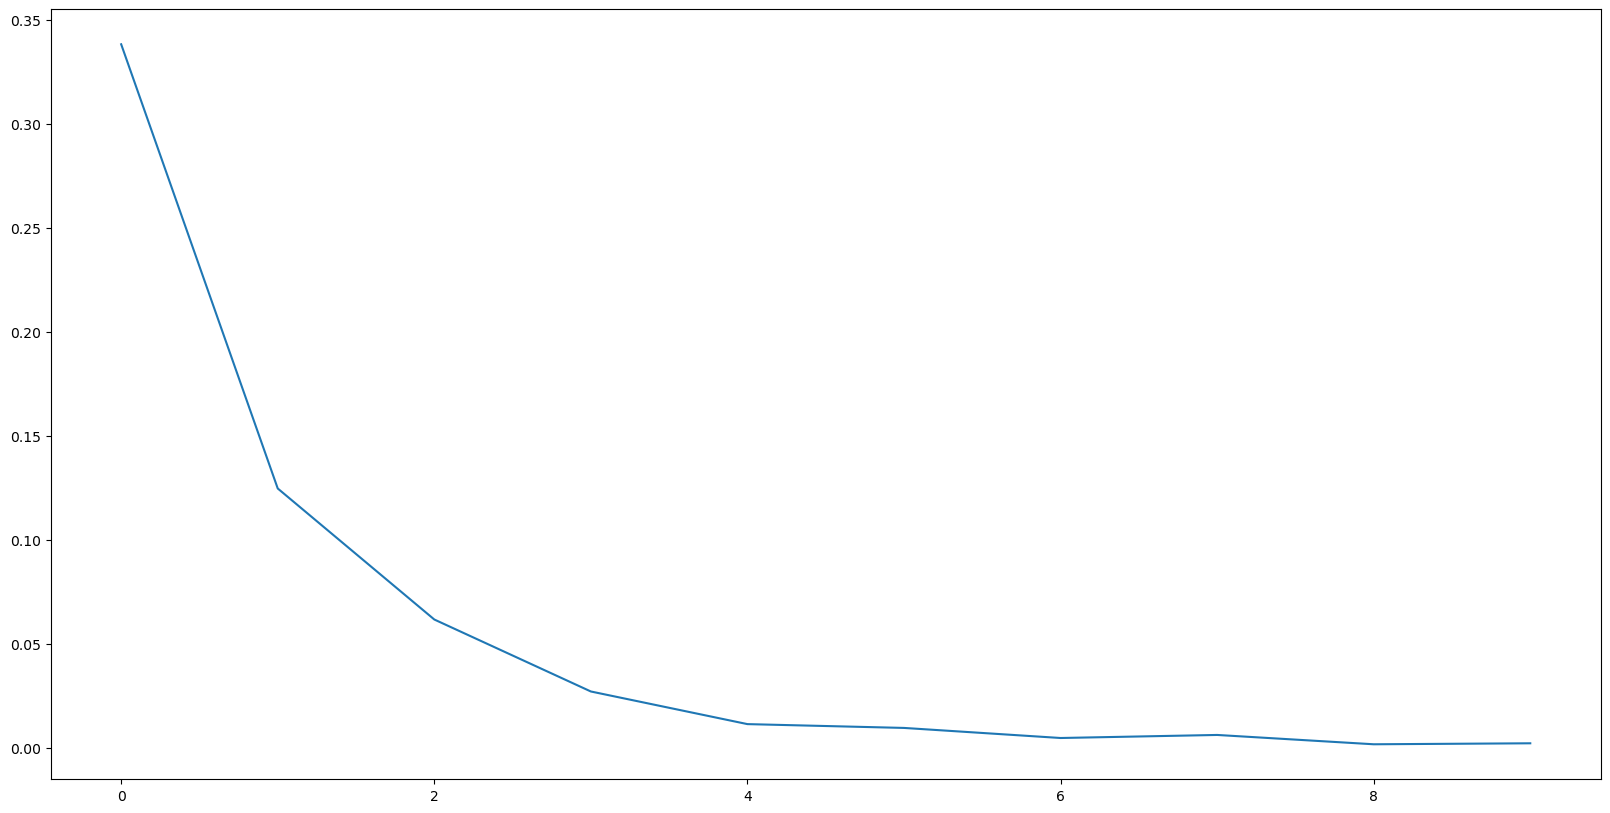

In [21]:
epochs_np = np.arange(0, num_epochs, 1)
losses_np = np.asarray(all_losses)

plt.figure(figsize=(20, 10))
plt.plot(epochs_np, losses_np)

## Model with dropouts

In [22]:
vocab_size = len(vocab)
embed_dim = 400
rnn_hidden_size = 128
fc_hidden_size = 128

torch.manual_seed(42)
model_with_dropouts = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, p_fc1=0.22, p_fc2=0.48, bidirec=False) 
print(model_with_dropouts)

RNN(
  (embedding): Embedding(22754, 400, padding_idx=0)
  (rnn): LSTM(400, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_fc1): Dropout(p=0.22, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout_fc2): Dropout(p=0.48, inplace=False)
  (sigmoid): Sigmoid()
)


### Training

In [23]:
torch.manual_seed(42)

loss_function, optimizer = get_loss_and_optimizer(model_with_dropouts)

num_epochs = 20
all_losses = []

for epoch in range(num_epochs):
    f1_train, loss_train, epoch_loss = train_model_for_one_epoch(train_dl, model_with_dropouts, 
                                                                 loss_function, optimizer)
    all_losses.append(epoch_loss)
    print(f'Epoch {epoch} | F1_score: {f1_train:.4f} | Loss: {loss_train:.4f}')

Epoch 0 | F1_score: 0.7562 | Loss: 0.4629
Epoch 1 | F1_score: 0.7850 | Loss: 0.3864
Epoch 2 | F1_score: 0.7921 | Loss: 0.3714
Epoch 3 | F1_score: 0.7945 | Loss: 0.3559
Epoch 4 | F1_score: 0.7960 | Loss: 0.3498
Epoch 5 | F1_score: 0.7992 | Loss: 0.3434
Epoch 6 | F1_score: 0.7982 | Loss: 0.3399
Epoch 7 | F1_score: 0.7957 | Loss: 0.3409
Epoch 8 | F1_score: 0.7988 | Loss: 0.3359
Epoch 9 | F1_score: 0.8015 | Loss: 0.3365
Epoch 10 | F1_score: 0.8036 | Loss: 0.3362
Epoch 11 | F1_score: 0.7996 | Loss: 0.3423
Epoch 12 | F1_score: 0.7989 | Loss: 0.3406
Epoch 13 | F1_score: 0.8012 | Loss: 0.3328
Epoch 14 | F1_score: 0.8004 | Loss: 0.3330
Epoch 15 | F1_score: 0.8013 | Loss: 0.3335
Epoch 16 | F1_score: 0.8010 | Loss: 0.3342
Epoch 17 | F1_score: 0.8015 | Loss: 0.3341
Epoch 18 | F1_score: 0.7996 | Loss: 0.3398
Epoch 19 | F1_score: 0.8013 | Loss: 0.3317


### Learning curve for the model with dropouts

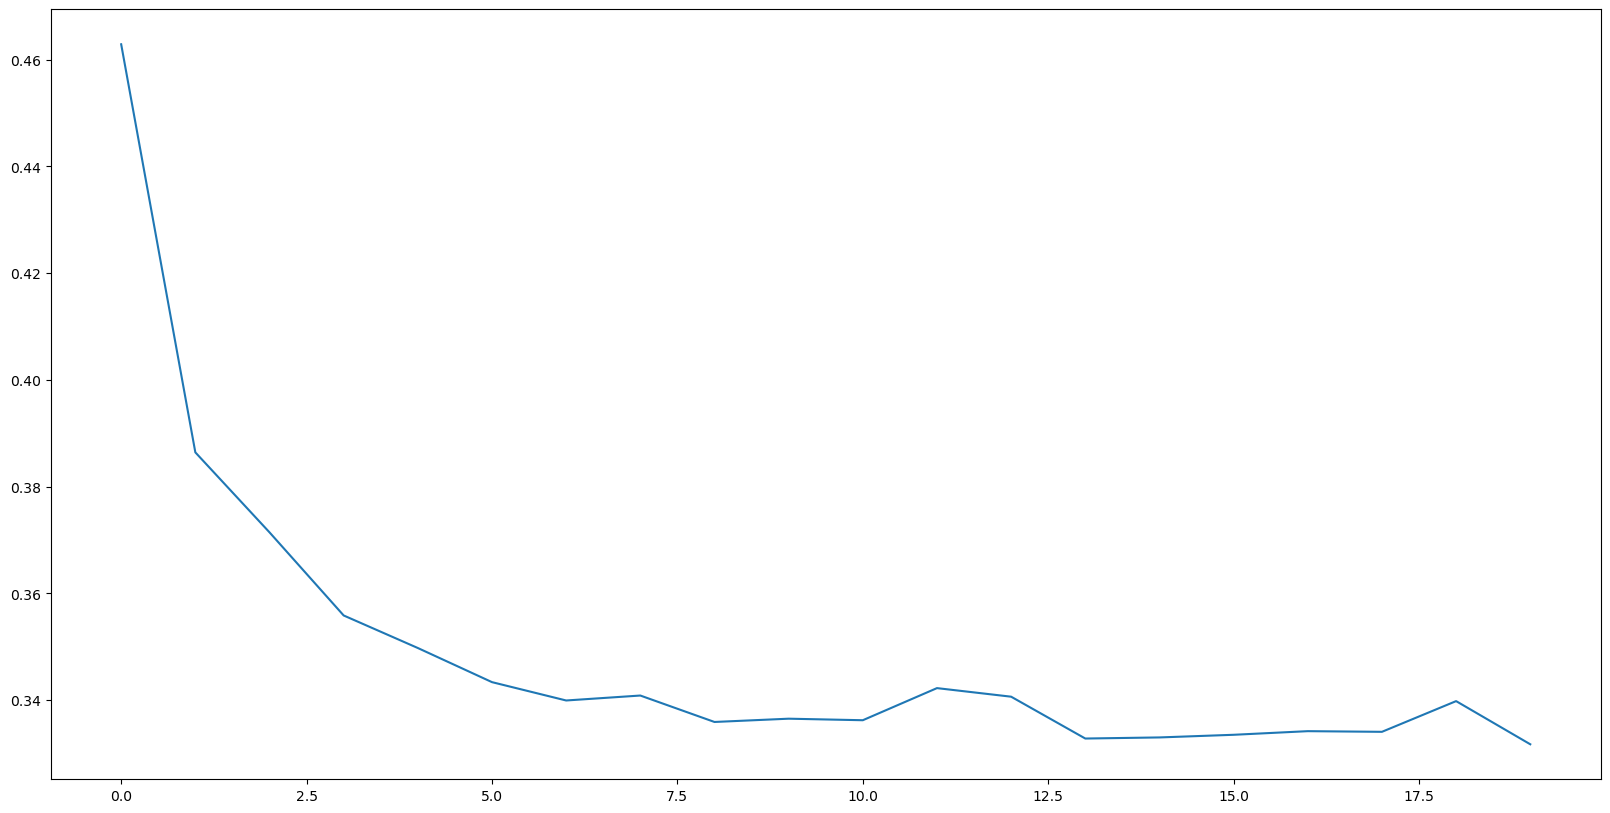

In [24]:
epochs_np = np.arange(0, num_epochs, 1)
losses_np = np.asarray(all_losses)

plt.figure(figsize=(20, 10))
plt.plot(epochs_np, losses_np)

# Save model with dropouts

In [25]:
torch.save(model_with_dropouts, 'model_with_dropouts')

### See "./validation.ipynb" for test-metrics and some examples